# CNN v1 with CIFAR-10

### Imports and dataset init

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU for PyTorch.")
else:
    print("CUDA is not available. Using CPU for PyTorch.")

CUDA is available. You can use GPU for PyTorch.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

# Creating train/vali split
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

valset.dataset.transform = transform_test  # For validation we switch to transform_test (no augmentation)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

In [6]:
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Building CNN

In [7]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3x32x32, Output: 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 32x16x16
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 64x8x8
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 128x8x8
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 128x4x4
            nn.Dropout(0.3),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),# 128x4x4
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 128x2x2
            nn.Dropout(0.3),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),# 128x2x2
            nn.ReLU(),
            nn.MaxPool2d(2),                            # 128x1x1
            nn.Dropout(0.4)
        )

        # 2 fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 1 * 1, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [8]:
model = BaseCNN().to(device)

learning_rate = 0.0005

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

### Training loop and eval

In [9]:
num_epochs = 150  # TODO: Add auto stopping criterion if loss is not decreasing
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    scheduler.step()

    epoch_loss = running_loss / len(trainloader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = val_running_loss / len(valloader.dataset)
    val_losses.append(epoch_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_loss:.8f}, Validation Loss: {epoch_val_loss:.8f}")

Epoch [10/150], Training Loss: 0.86298692, Validation Loss: 0.75157777
Epoch [20/150], Training Loss: 0.65031064, Validation Loss: 0.63873262
Epoch [30/150], Training Loss: 0.54038747, Validation Loss: 0.57356408
Epoch [40/150], Training Loss: 0.49658449, Validation Loss: 0.55834454
Epoch [50/150], Training Loss: 0.44687719, Validation Loss: 0.54298518
Epoch [60/150], Training Loss: 0.42764755, Validation Loss: 0.56037715
Epoch [70/150], Training Loss: 0.40474471, Validation Loss: 0.54090178
Epoch [80/150], Training Loss: 0.39468672, Validation Loss: 0.54116474
Epoch [90/150], Training Loss: 0.38445926, Validation Loss: 0.54021442
Epoch [100/150], Training Loss: 0.38210175, Validation Loss: 0.53230478
Epoch [110/150], Training Loss: 0.38130950, Validation Loss: 0.53416268
Epoch [120/150], Training Loss: 0.37121356, Validation Loss: 0.53457372
Epoch [130/150], Training Loss: 0.37003817, Validation Loss: 0.53367617
Epoch [140/150], Training Loss: 0.36747574, Validation Loss: 0.53235557
E

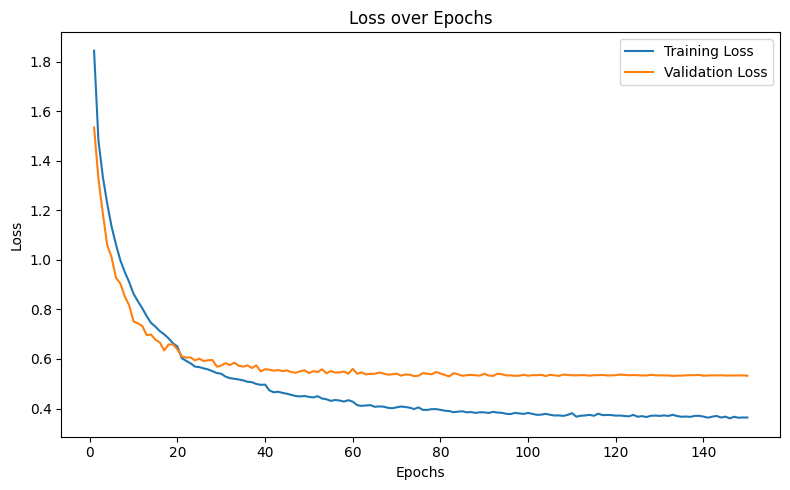

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print("\nTest Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=testset.classes, zero_division=0))


Test Metrics:
Accuracy: 0.8197
Precision: 0.8194
Recall: 0.8197
F1-Score: 0.8185

Classification Report:
               precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      1000
  automobile       0.94      0.90      0.92      1000
        bird       0.78      0.71      0.74      1000
         cat       0.69      0.62      0.65      1000
        deer       0.75      0.83      0.79      1000
         dog       0.75      0.72      0.73      1000
        frog       0.79      0.91      0.85      1000
       horse       0.88      0.85      0.86      1000
        ship       0.89      0.92      0.90      1000
       truck       0.89      0.89      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



### Show random predictions

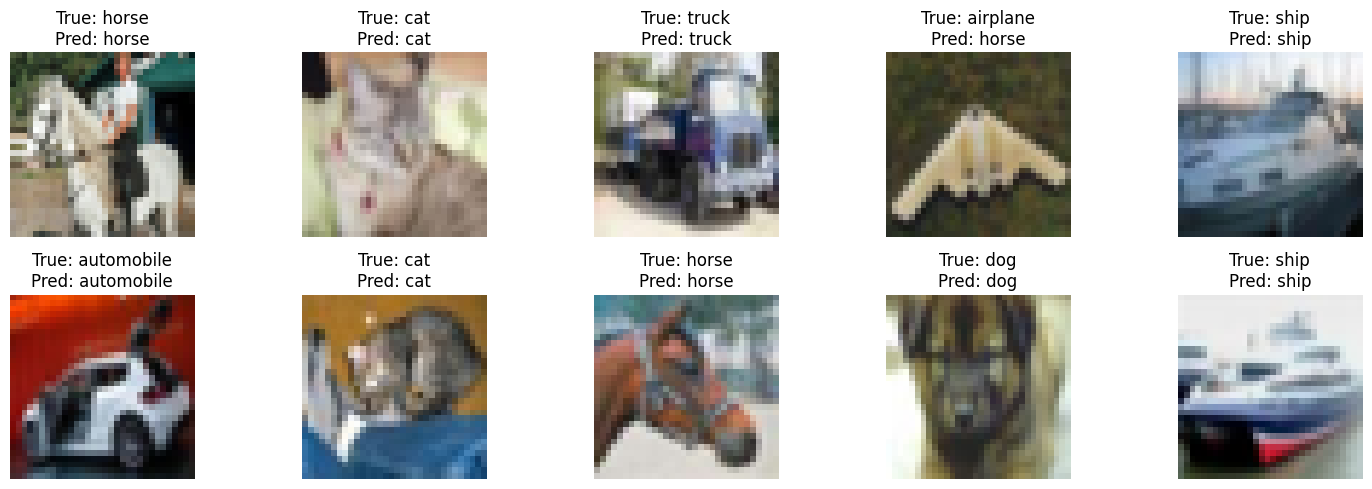

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # remove normalization from transform
    np_img = img.numpy().transpose(1, 2, 0)
    plt.imshow(np_img)
    plt.axis('off')

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

indices = random.sample(range(images.size(0)), 10)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    imshow(images[idx].cpu())
    true_label = testset.classes[labels[idx].item()]
    pred_label = testset.classes[preds[idx].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.tight_layout()
plt.show()